In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA
import scipy

In [2]:
ph=1.5574E-4
times=[1,2,3,6,7,9,13,16,21,24,31] 
pxt=[(x) for x in list(range(3,50,1))]
neh=range(1,120)
# path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/liverpool_liver_31_test/"

In [3]:
all_AAs=['a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p','q', 'r', 's', 't', 'v', 'w', 'y']
def charcount(pepSeq):
    res={key: 0 for key in all_AAs}     
    for c in pepSeq.lower():
        if c.isalpha():
            res[c]+=1
    return res

In [4]:
def getPeptiedsInfo(protien,time):
    print(protien,time)
    peptides=[x.split(f'_{time}_')[0] for x in os.listdir(path) if (protien+".csv" in x) and (f"_{time}_" in x)]
    peptides=[x  for x in peptides if 'A' in x]
    peptidesinfo=dict()
    print(len(peptides))
    

    for k in range(len(peptides)): 
        data=pd.read_csv(f"{path}{peptides[k]}_{time}_{protien}.csv")
        data["pxt_neh"]=data.NEH*data.pxt
        data=data[["NEH","pxt","RMSE","pxt_neh","T_NEH","NH"]] 
        minval=min(data.RMSE)

        data=data[data.RMSE==minval]

        peptidesinfo[peptides[k]]={"pxt_neh":float(data.pxt_neh),"T_NEH":float(data.T_NEH),"Seq":peptides[k],
                               "charcount":charcount(peptides[k])}
           
    visited=set()
    visited.add(peptides[0].split('_')[1])
    coefficients=[]
    for k in range(0,len(peptides)-1):
        if(peptides[k+1].split('_')[1] in visited):
            continue

        pep1=peptidesinfo[peptides[k]]
        pep2=peptidesinfo[peptides[k+1]]    
        visited.add(peptides[k].split('_')[1])

        r=pep1["pxt_neh"]/pep2["pxt_neh"]
        coefficients.append([pep1["charcount"][c]-r*pep2["charcount"][c] for c in all_AAs])
        
    return peptides,peptidesinfo,all_AAs,np.array(coefficients)


In [5]:
def compute_result(peptides,peptidesinfo,all_AAs,sol):
    t_neh,e_neh=[],[]
    for i in range (len(peptides)):
        pep1=peptidesinfo[peptides[i]]
        p_neh=0
        for index,c in enumerate(all_AAs): 
            p_neh+=(pep1["charcount"][c]*sol[index]) 
        t_neh.append(pep1["T_NEH"])
        e_neh.append(p_neh)

    res=pd.DataFrame([peptides,t_neh,e_neh])
    res=res.transpose()
    res.columns=["peptides","True_NEH","e_NEH"]
    res["dif"]=abs(res.True_NEH-res.e_NEH)
#     print(np.mean(res.dif),np.median(res.dif),np.std(res.dif))
    return res.sort_values(by='dif')

In [6]:
e_vals=[]
for time in times[3:]:
    print(time,"===========================================")
    # time=9
    a_val=4
    # w_val=0.08
    # proteins=["CPSM_MOUSE","FAS_MOUSE","DHB4_MOUSE","ASSY_MOUSE","ATPA_MOUSE","ATPB_MOUSE","BHMT1_MOUSE",
    #          "CLH1_MOUSE","DHE3_MOUSE","DHSO_MOUSE","ECHA_MOUSE",
    #          "G3P_MOUSE","HMCS2_MOUSE","HYES_MOUSE","MYH9_MOUSE","PYC_MOUSE","PYGL_MOUSE","SAHH_MOUSE",
    #          "SARDH_MOUSE","SBP1_MOUSE","THIM_MOUSE","TKT_MOUSE"]
    # proteins=pd.read_csv("H:/Warehouse/Data/liverpool/liver/6_23_2022_c/"+"Analyzed_Proteins_and_Their_Rates.csv").Proteins.unique()

    path="C:/Workplace/C++/d2ome_v2/v2/v2/bin/Debug/second_r_liver/" 
    proteins=np.unique(["_".join(x.split('_')[4:]).replace('.csv','') for x in os.listdir(path) if ("_MOUSE.csv" in x)])

    coefficients=np.array([])
    _peptides,_peptidesinfo=[],[]
    for protine in proteins:
        try:
            peptides1,peptidesinfo1,all_AAs1,coefficients1=getPeptiedsInfo(protine,time) 
            print(protine,len(all_AAs1)==20)
            if(coefficients.shape[0]==0):
                coefficients=coefficients1
            else:
                coefficients=np.concatenate((coefficients1,coefficients), axis=0)
            _peptides.append(peptides1)
            _peptidesinfo.append(peptidesinfo1)
        except:
            continue

    # sol=list(scipy.optimize.nnls(coefficients[:,2 :],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])
    sol=list(scipy.optimize.nnls(coefficients[:,1:],-a_val*coefficients[:,0])[0])
    # sol=list(scipy.optimize.nnls(coefficients[:,2:],-a_val*coefficients[:,0]-w_val*coefficients[:,1])[0])

    print("====>",len(sol))
    sol.insert(0,a_val) 
    # sol.insert(1,w_val) 
    print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))
    res=pd.DataFrame()
    for i in range(len(proteins)):
        res=pd.concat([res,compute_result(_peptides[i],_peptidesinfo[i],all_AAs1,sol)])

    print("\nstats",np.mean(res.dif),np.median(res.dif),np.std(res.dif))    
    
    e_vals.append(sol)
 

6 ===========================================
AL1L1_MOUSE 6
17
AL1L1_MOUSE True
AL3A2_MOUSE 6
4
AL3A2_MOUSE True
ALDOB_MOUSE 6
8
ALDOB_MOUSE True
AMPL_MOUSE 6
7
AMPL_MOUSE True
ASSY_MOUSE 6
10
ASSY_MOUSE True
ATPA_MOUSE 6
15
ATPA_MOUSE True
ATPB_MOUSE 6
15
ATPB_MOUSE True
BIP_MOUSE 6
8
BIP_MOUSE True
CAH3_MOUSE 6
11
CAH3_MOUSE True
CATA_MOUSE 6
11
CATA_MOUSE True
CPSM_MOUSE 6
24
CPSM_MOUSE True
DHB4_MOUSE 6
6
DHB4_MOUSE True
DHE3_MOUSE 6
6
DHE3_MOUSE True
DHSO_MOUSE 6
10
DHSO_MOUSE True
ECHA_MOUSE 6
9
ECHA_MOUSE True
EF2_MOUSE 6
5
EF2_MOUSE True
ENOA_MOUSE 6
7
ENOA_MOUSE True
EST1D_MOUSE 6
5
EST1D_MOUSE True
ETFA_MOUSE 6
7
ETFA_MOUSE True
F16P1_MOUSE 6
10
F16P1_MOUSE True
FAAA_MOUSE 6
7
FAAA_MOUSE True
FAS_MOUSE 6
13
FAS_MOUSE True
GRP75_MOUSE 6
7
GRP75_MOUSE True
PBLD1_MOUSE 6
8
PBLD1_MOUSE True
PDIA1_MOUSE 6
9
PDIA1_MOUSE True
PGM1_MOUSE 6
8
PGM1_MOUSE True
PYC_MOUSE 6
9
PYC_MOUSE True
PYGL_MOUSE 6
8
PYGL_MOUSE True
RGN_MOUSE 6
6
RGN_MOUSE True
SAHH_MOUSE 6
7
SAHH_MOUSE True
SARDH_MO

15
ATPB_MOUSE True
BIP_MOUSE 21
8
BIP_MOUSE True
CAH3_MOUSE 21
11
CAH3_MOUSE True
CATA_MOUSE 21
11
CATA_MOUSE True
CPSM_MOUSE 21
24
CPSM_MOUSE True
DHB4_MOUSE 21
6
DHB4_MOUSE True
DHE3_MOUSE 21
6
DHE3_MOUSE True
DHSO_MOUSE 21
10
DHSO_MOUSE True
ECHA_MOUSE 21
9
ECHA_MOUSE True
EF2_MOUSE 21
5
EF2_MOUSE True
ENOA_MOUSE 21
7
ENOA_MOUSE True
EST1D_MOUSE 21
5
EST1D_MOUSE True
ETFA_MOUSE 21
7
ETFA_MOUSE True
F16P1_MOUSE 21
10
F16P1_MOUSE True
FAAA_MOUSE 21
7
FAAA_MOUSE True
FAS_MOUSE 21
13
FAS_MOUSE True
GRP75_MOUSE 21
7
GRP75_MOUSE True
PBLD1_MOUSE 21
8
PBLD1_MOUSE True
PDIA1_MOUSE 21
9
PDIA1_MOUSE True
PGM1_MOUSE 21
8
PGM1_MOUSE True
PYC_MOUSE 21
9
PYC_MOUSE True
PYGL_MOUSE 21
8
PYGL_MOUSE True
RGN_MOUSE 21
6
RGN_MOUSE True
SAHH_MOUSE 21
7
SAHH_MOUSE True
SARDH_MOUSE 21
8
SARDH_MOUSE True
THIL_MOUSE 21
7
THIL_MOUSE True
THIM_MOUSE 21
6
THIM_MOUSE True
UD11_MOUSE 21
5
UD11_MOUSE True
====> 19

Values
 a= 4
c= 1.6992359304248084
d= 2.3466973448690607
e= 3.549909030422447
f= 0.2648074760245357

In [7]:
evals2=np.array(e_vals)
trueval=[4.0,1.62,1.89,3.95,0.32,2.06,2.88,1.0,0.6,0.54,1.12,1.89,2.59,3.95,3.43,2.61,0.2,0.56,0.08,0.42]

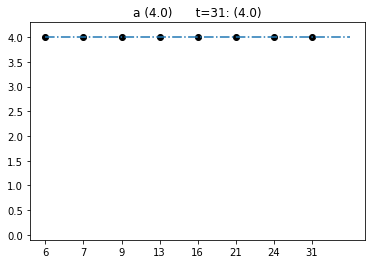

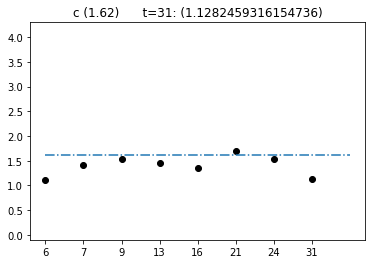

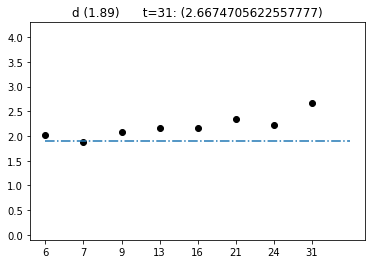

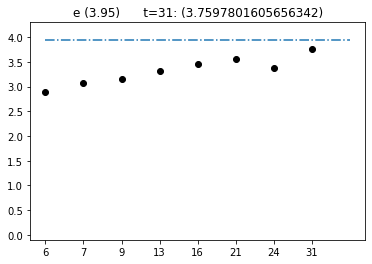

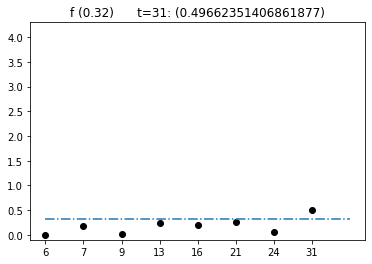

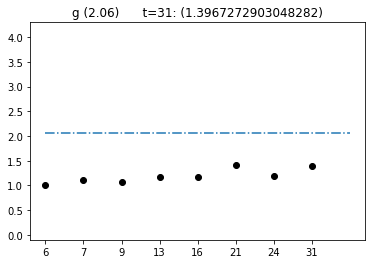

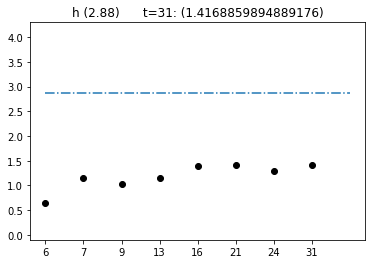

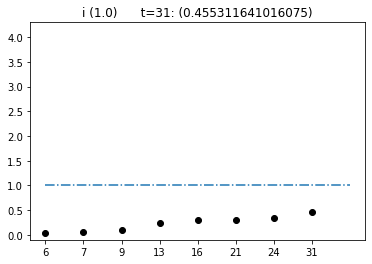

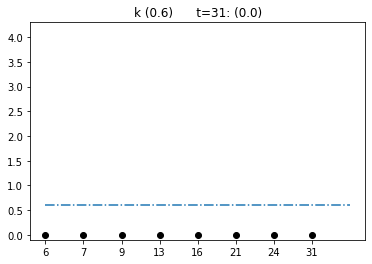

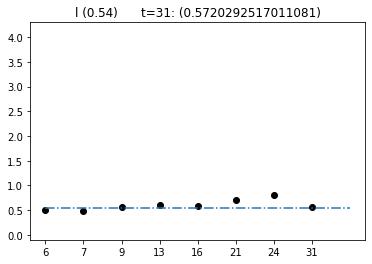

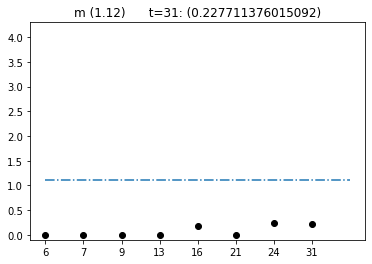

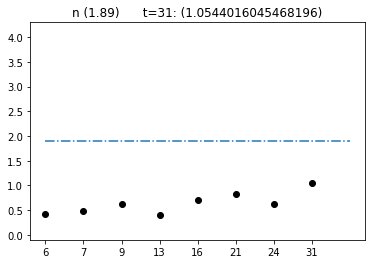

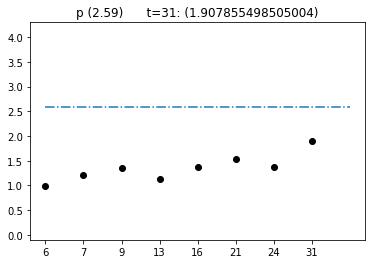

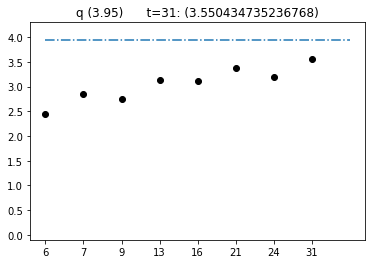

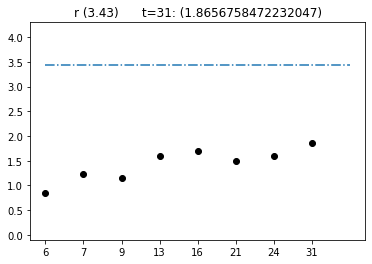

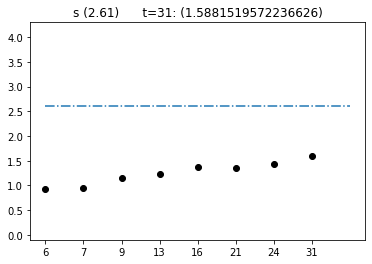

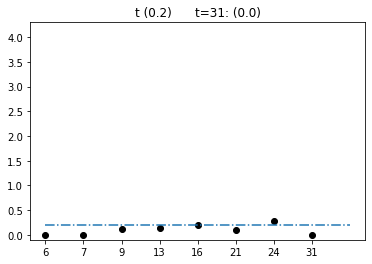

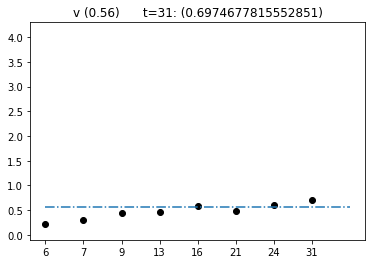

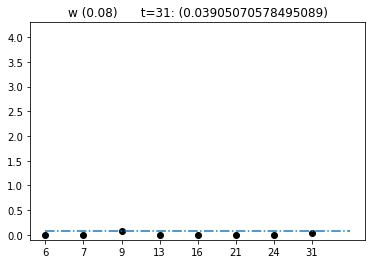

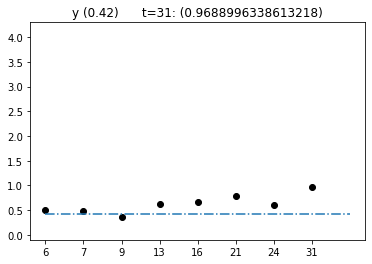

In [15]:
for i in range(len(all_AAs1)):
    plt.scatter(range(8),evals2[:,i],c='k')
    plt.xticks(np.arange(8), times[3:])
    plt.title(all_AAs1[i]+f" ({trueval[i]})"+f"      t=31: ({evals2[:,i][-1]})")
    plt.ylim([-0.1,4.3])
    plt.hlines(y=trueval[i],xmin=0,xmax=8,linestyle="-.")
    plt.show()
    

In [9]:
print("\nValues\n","\n".join([all_AAs1[index]+"= "+str(x) for index,x in enumerate(sol)]))


Values
 a= 4
c= 1.1282459316154736
d= 2.6674705622557777
e= 3.7597801605656342
f= 0.49662351406861877
g= 1.3967272903048282
h= 1.4168859894889176
i= 0.455311641016075
k= 0.0
l= 0.5720292517011081
m= 0.227711376015092
n= 1.0544016045468196
p= 1.907855498505004
q= 3.550434735236768
r= 1.8656758472232047
s= 1.5881519572236626
t= 0.0
v= 0.6974677815552851
w= 0.03905070578495089
y= 0.9688996338613218


In [10]:
print("proteins",len(proteins),"peptides",res.shape[0])

proteins 34 peptides 303


In [11]:
res=res.sort_values(by='dif')
res.head(20)

,peptides,True_NEH,e_NEH,dif
6,_EAYPGDVFYLH_2,19.0,18.852639,0.147361
7,_YDYEEVEAEGANK_2,31.0,30.792987,0.207013
5,_GEFQILLDALDK_2,21.0,20.709906,0.290094
1,_DYYFALAHTVR_3,18.0,17.653952,0.346048
4,_VAVVAGYGDVGK_2,19.0,18.616423,0.383577
1,_DILQDVLDADLSNEAFPF_2,34.0,34.39262,0.39262
2,_EKGEFQILLDALDK_2,25.0,24.469686,0.530314
3,_EKGEFQILLDALDK_3,25.0,24.469686,0.530314
8,_TIEYLEEVAVNFAK_3,25.0,24.221542,0.778458
5,_VFDYSEYWEGAR_2,23.0,22.208527,0.791473


In [12]:
res.tail(20)

,peptides,True_NEH,e_NEH,dif
1,_APSSSSVGISEWLDQK_2,34.0,26.986887,7.013113
1,_GHEVVVIAPEASIHIK_3,34.0,26.704405,7.295595
2,_GHEVVVIAPEASIHIK_4,34.0,26.704405,7.295595
12,_WLSTSIPEAQWQSSLAR_2,38.0,30.66426,7.33574
1,_ASQRPDVLTTGGGNPIGDK_3,36.0,28.521034,7.478966
0,_ASQRPDVLTTGGGNPIGDK_2,36.0,28.521034,7.478966
7,_HIGSSVEFDWcAVSSIR_3,33.0,25.428627,7.571373
4,_LFDHPEVPTPPESASVSR_3,40.0,32.329059,7.670941
8,_HLGIVGEcNIQFALHPT_3,32.0,24.276718,7.723282
5,_MRPDNSKPPVYGAcR_2,31.0,23.183994,7.816006


In [13]:
temp=pd.DataFrame(coefficients)
temp.columns=all_AAs1
temp 

,a,c,d,e,f,g,h,i,k,l,m,n,p,q,r,s,t,v,w,y
0,-0.960000,0.00000,1.000000,-0.960000,0.000000,-0.980000,-1.960000,-1.940000,-0.980000,3.000000,1.000000,0.000000,0.020000,1.000000,1.000000,1.020000,1.000000,-0.940000,1.00000,0.000000
1,0.163265,0.00000,0.000000,0.163265,0.000000,0.081633,0.163265,0.244898,0.081633,0.000000,0.000000,0.000000,0.081633,0.000000,0.000000,0.081633,0.000000,0.244898,0.00000,0.000000
2,0.333333,0.00000,-1.666667,2.000000,-3.333333,1.000000,2.000000,3.000000,1.000000,-3.333333,0.000000,-1.666667,1.000000,-1.666667,-1.666667,-0.666667,-1.666667,3.000000,0.00000,0.000000
3,0.265000,0.00000,1.000000,-0.735000,2.000000,-0.735000,0.000000,-0.735000,-0.735000,0.530000,0.000000,1.000000,-0.735000,0.265000,1.000000,-0.470000,0.265000,-1.470000,0.00000,-1.470000
4,-2.272727,0.00000,2.000000,-0.090909,0.000000,-0.090909,1.000000,0.000000,-0.090909,0.818182,-2.181818,-1.090909,-1.090909,1.000000,0.000000,0.000000,0.909091,1.000000,1.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,-0.846154,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.076923,-0.846154,0.000000,2.000000,-1.846154,0.076923,0.000000,0.000000,0.153846,1.076923,0.00000,1.000000
256,0.916666,0.00000,-0.541667,-1.083334,-1.083334,-1.625001,0.000000,-0.541667,0.458333,1.458333,0.000000,0.000000,2.000000,0.458333,0.000000,0.000000,2.000000,0.458333,0.00000,0.000000
257,1.104373,0.00000,1.000000,-0.686880,2.000000,1.208746,0.000000,0.104373,0.104373,1.000000,0.000000,0.000000,-1.791254,-0.791254,-0.895627,0.000000,-0.895627,1.000000,0.00000,-0.895627
258,-3.224135,0.00000,-2.112067,3.000000,-4.224135,-2.224135,0.000000,1.000000,-1.112067,0.000000,0.000000,0.000000,-0.112067,2.000000,1.000000,0.000000,-1.112067,-2.112067,0.00000,1.000000


In [14]:
# for c in range( len(coefficients)):
#     print(np.dot(coefficients[c],sol))